In [1]:
from variational_autoencoder import VariationalAutoEncoder
from verification_net import VerificationNet
from stacked_mnist import StackedMNIST, DataMode

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps")
torch.mps.set_per_process_memory_fraction(0.)

model_file = Path("models/vae-basic")

In [3]:
class StackedVAE(VariationalAutoEncoder):
    def __init__(self, latent_space_size: int = 64) -> None:
        super().__init__(latent_space_size)

    def forward(self, x):
        nb_channels = x.shape[1]
        mus, log_vars = [], []
        x_hat = []
        for channel in range(nb_channels):
            x_channel = x[:, [channel], :, :]
            mu, log_var = self.encoder(x_channel)

            mus.append(mu.view(-1, 1, self.latent_space_size))
            log_vars.append(log_var.view(-1, 1, self.latent_space_size))

            std = torch.sqrt(torch.exp(log_var))
            eps = torch.randn_like(std)

            z = mu + eps * std
            x_hat.append(self.decoder(z))

        mus = torch.cat(mus, dim=1)
        log_vars = torch.cat(log_vars, dim=1)
        x_hat = torch.cat(x_hat, dim=1)
        return (mus, log_vars), x_hat


In [4]:
VAE = StackedVAE()
VAE.load_state_dict(torch.load(model_file))

VAE.to(device)

StackedVAE(
  (encoder): VariationalEncoder(
    (main): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (mu): Linear(in_features=1600, out_features=64, bias=True)
    (log_var): Linear(in_features=1600, out_features=64, bias=True)
  )
  (decoder): VariationalDecoder(
    (main): Sequential(
      (0): Linear(in_features=64, out_features=1600, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(64, 5, 5))
      (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ConvTranspose2d(64

In [5]:
def loss(X, params):
    x_hat, x = X
    mu, log_var = params
    
    BCE = F.binary_cross_entropy(x_hat, x, reduction='mean')
    KLD = torch.mean(- 0.5 * torch.mean(1 + log_var - mu.pow(2) - torch.exp(log_var), axis=1))

    return BCE + .06 * KLD

In [6]:
mode = DataMode.COLOR | DataMode.BINARY

In [7]:
trainset = StackedMNIST(train=True, mode=mode)
testset = StackedMNIST(train=False, mode=mode)

/Users/arthurtestard/envs/ntnu/deeplearning/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
batch_size = 1
data = DataLoader(trainset, shuffle=True, batch_size=batch_size)
x, _, labels = next(iter(data))

In [9]:
train_loader = DataLoader(dataset=trainset, shuffle=True, batch_size=2048)
test_loader = DataLoader(dataset=testset, shuffle=True, batch_size=2048)

In [10]:
from util import tile_tv_images, tile_pil_images
from torchvision.transforms import ToPILImage

def print_reconstructed_img(dataset, batch_size: int = 25):
    data = DataLoader(dataset, shuffle=True, batch_size=batch_size)
    imgs, _, labels = next(iter(data))

    _, imgs_pred = VAE(imgs.to(device))
    
    labels = labels.detach().numpy()
    imgs_pil = [ ToPILImage()(img_pred.cpu()) for img_pred in imgs_pred ]
    tile_pil_images(images=imgs_pil)

In [11]:
data = DataLoader(trainset, shuffle=True, batch_size=1000)
imgs, _, labels = next(iter(data))

_, imgs_pred = VAE(imgs.to(device))
imgs_pred.shape

torch.Size([1000, 3, 28, 28])

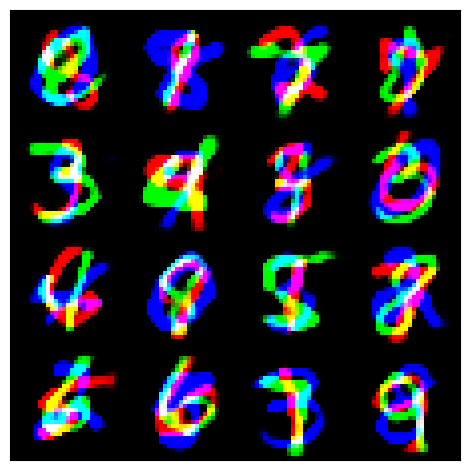

In [14]:
print_reconstructed_img(trainset, batch_size=16)

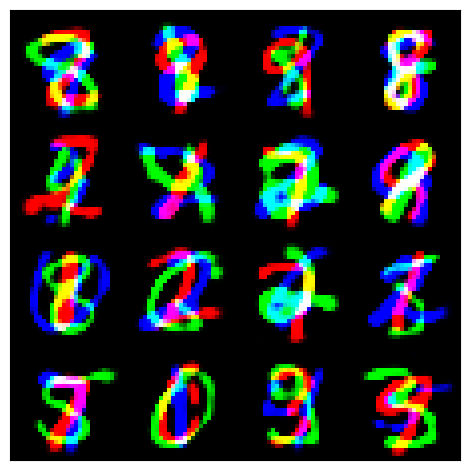

In [15]:
print_reconstructed_img(testset, batch_size=16)

In [16]:
VerifNet = VerificationNet(force_learn=False, file_name='models/verification_model')

data = DataLoader(trainset, shuffle=True, batch_size=10000)
imgs, _, labels = next(iter(data))

labels = labels.detach().numpy()
_, preds = VAE(imgs.to(device))

cov = VerifNet.check_class_coverage(data=imgs, tolerance=.8)
pred, acc = VerifNet.check_predictability(data=preds, correct_labels=labels, tolerance=.8)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 97.31%
Accuracy: 90.01%


In [17]:
data = DataLoader(testset, shuffle=True, batch_size=10000)
imgs, _, labels = next(iter(data))

labels = labels.detach().numpy()
_, preds = VAE(imgs.to(device))

cov = VerifNet.check_class_coverage(data=imgs, tolerance=.8)
pred, acc = VerifNet.check_predictability(data=preds, correct_labels=labels, tolerance=.8)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 97.47%
Accuracy: 89.47%


In [18]:
def errorbar_classification(classes, mean_accuracy, std_accuracy):
    x = classes
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, mean_accuracy, width, yerr=std_accuracy, label='Accuracy')

    ax.set_ylabel('p(x)')
    ax.set_title('p(x)')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    plt.show()

In [19]:
data = DataLoader(testset, shuffle=True, batch_size=10000)
imgs, _, labels = next(iter(data))

labels = labels.detach().numpy()
imgs = imgs.to(device)
_, preds = VAE(imgs)

In [20]:
nb_samples = 100

In [21]:
from tqdm import tqdm

class_accuracies = [[] for _ in range(1000)]
probas = []
nb_channels = 3

for x, label in tqdm(zip(imgs, labels)):
    x = x.view(1, 3, 28, 28)
    x_hat = []
    for channel in range(nb_channels):
        x_channel = x[:, [channel], :, :]
        
        mu, log_var = VAE.encoder(x_channel)
        std = torch.sqrt(torch.exp(log_var))
        eps = torch.randn_like(std.expand(nb_samples,64)).to(device)

        z = mu + eps * std
        x_hat.append(VAE.decoder(z))

    x_hat = torch.cat(x_hat, dim=1)
    

    x = x.expand(nb_samples, 3, 28, 28)
    class_accuracies[label].append((-F.binary_cross_entropy(x_hat, x)).exp().mean().cpu().detach().numpy())
    probas.append((-F.binary_cross_entropy(x_hat, x)).exp().mean().cpu().detach().numpy())
    
mean_accuracy = [np.mean(acc) for acc in class_accuracies]
std_accuracy = [np.std(acc) for acc in class_accuracies]

probas = np.array(probas)

10000it [03:05, 53.91it/s]


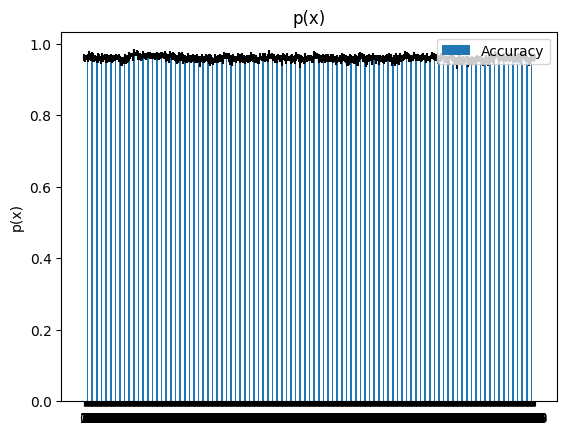

In [22]:
errorbar_classification(np.arange(1000), mean_accuracy=mean_accuracy, std_accuracy=std_accuracy)

In [23]:
def top_anomalous(k, losses, preds, labels, is_bottom = True):
    idx = np.argsort(losses)[:k] if is_bottom else np.flip(np.argsort(losses))[:k]

    new_labels = [ 
        str(f"p(x={labels[_id]}) = {int(losses[_id] * 1e3) / 1e3}") for _id in idx
        ]
    
    tile_tv_images(images=preds[idx], labels=new_labels)

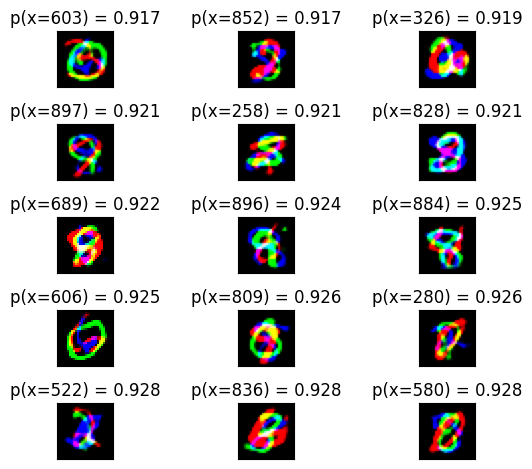

In [24]:
top_anomalous(15, probas, preds.permute(0, 2, 3, 1).cpu().detach().numpy(), labels)

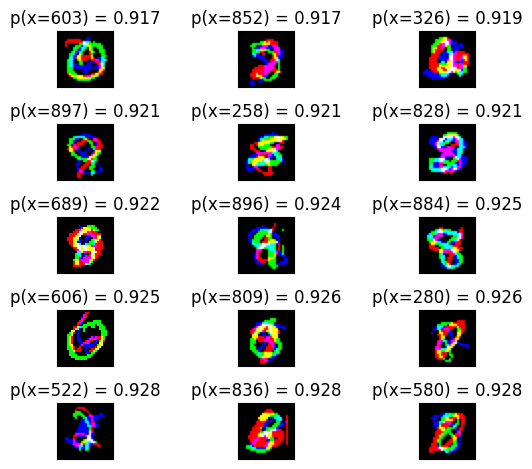

In [25]:
top_anomalous(15, probas, imgs.permute(0, 2, 3, 1).cpu().detach().numpy(), labels)

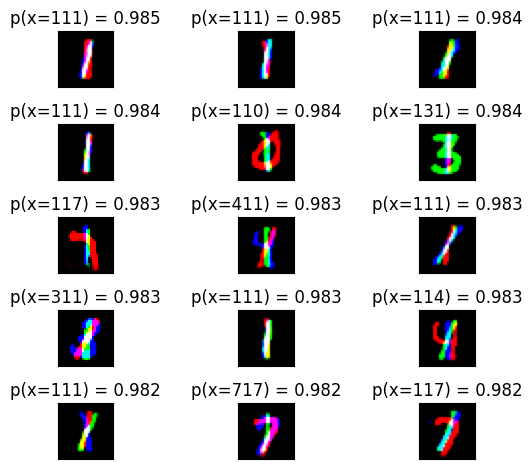

In [26]:
top_anomalous(15, probas, preds.permute(0, 2, 3, 1).cpu().detach().numpy(), labels, is_bottom=False)


(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: title={'center': 'p(x=479)=0.941'}>,
         <Axes: title={'center': 'p(x=828)=0.942'}>,
         <Axes: title={'center': 'p(x=588)=0.944'}>,
         <Axes: title={'center': 'p(x=808)=0.945'}>],
        [<Axes: title={'center': 'p(x=608)=0.945'}>,
         <Axes: title={'center': 'p(x=626)=0.945'}>,
         <Axes: title={'center': 'p(x=986)=0.946'}>,
         <Axes: title={'center': 'p(x=585)=0.946'}>],
        [<Axes: title={'center': 'p(x=258)=0.946'}>,
         <Axes: title={'center': 'p(x=884)=0.946'}>,
         <Axes: title={'center': 'p(x=788)=0.946'}>,
         <Axes: title={'center': 'p(x=868)=0.947'}>],
        [<Axes: title={'center': 'p(x=280)=0.947'}>,
         <Axes: title={'center': 'p(x=682)=0.948'}>,
         <Axes: title={'center': 'p(x=860)=0.948'}>,
         <Axes: title={'center': 'p(x=388)=0.948'}>]], dtype=object))

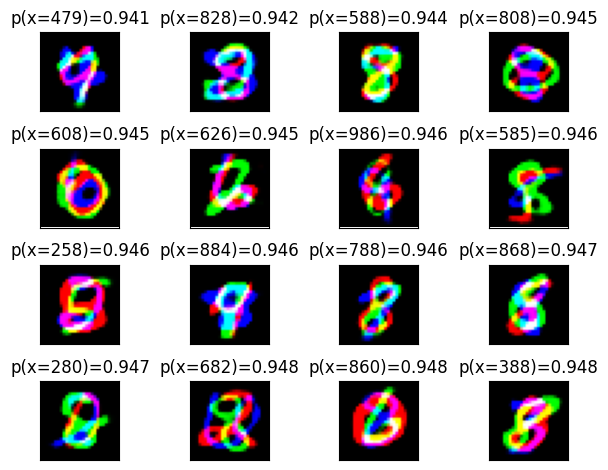

In [29]:
x_values = np.argsort(mean_accuracy)[:16]
is_color = preds.shape[1] == 3

new_labels = [ 
    str(f"p(x={x_value})={int(mean_accuracy[x_value] * 1e3) / 1e3}") for x_value in x_values
    ]
np_imgs_predicted = preds.reshape(-1, 28, 28).cpu().detach().numpy() if not is_color else preds.permute(0,2,3,1).cpu().detach().numpy()

anomalies_pred = np.array([ np_imgs_predicted[np.argwhere(labels == x_value)[:,0]][0] for x_value in x_values ])

tile_tv_images(images=anomalies_pred, labels=new_labels)
